In [1]:
%pip install lime

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [2]:
%load_ext autoreload
%autoreload 2

In [3]:
from google.colab import drive
drive.mount('/content/drive/')

Drive already mounted at /content/drive/; to attempt to forcibly remount, call drive.mount("/content/drive/", force_remount=True).


In [4]:
import sys
sys.path.append('/content/drive/MyDrive/Documents importants/Academic/MIT/Fall/15_572_Analytics_lab/Google Colab - ALab/Notebooks/src')

In [5]:
from utils import *
from nlp_utils import *

In [6]:
# remove warnings
import warnings
warnings.filterwarnings('ignore')

# automatically refresh imported modules
%reload_ext autoreload
%autoreload 2

## for data
import json
import pandas as pd
from tqdm import tqdm
tqdm.pandas()
import numpy as np
## for plotting
import matplotlib.pyplot as plt
import seaborn as sns
## for processing
import re
import nltk
## for bag-of-words
from sklearn import feature_extraction, model_selection, naive_bayes, pipeline, manifold, preprocessing, feature_selection
from sklearn.metrics import precision_recall_curve
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import GradientBoostingClassifier

## for explainer
from lime import lime_text

## for word embedding
import gensim
import gensim.downloader as gensim_api
from sklearn import metrics

In [7]:
import nltk
nltk.download('stopwords')
nltk.download('wordnet')
nltk.download('omw-1.4')

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package omw-1.4 to /root/nltk_data...
[nltk_data]   Package omw-1.4 is already up-to-date!


True

In [8]:
path = '/content/drive/MyDrive/Documents importants/Academic/MIT/Fall/15_572_Analytics_lab/Google Colab - ALab/Data/ML_NOAC_NOVA_Extraction_Cleaned_DF3_Full.csv'
df = pd.read_csv(path)

var_used = "Emails"

df["ContactEmail"] = df["ContactEmail"].str.replace("@", " ")
df["ContactEmail"] = df["ContactEmail"].str.replace(".", " ")
df["ContactEmail"] = df["ContactEmail"].str.replace("_", " ")
df["ContactEmail"] = df["ContactEmail"].str.replace("-", " ")

df["LastEmailCCAddress"] = df["LastEmailCCAddress"].str.replace("@", " ")
df["LastEmailCCAddress"] = df["LastEmailCCAddress"].str.replace(".", " ")
df["LastEmailCCAddress"] = df["LastEmailCCAddress"].str.replace("_", " ")
df["LastEmailCCAddress"] = df["LastEmailCCAddress"].str.replace("-", " ")

df["Emails"] = df["ContactEmail"] + df["LastEmailCCAddress"]

df.head()

,index,CaseNumber,Type,Topics,TeamName,RequesterEmail,EmailObject,LastEmailCCAddress,AttributesURL,ContactAttributesURL,ContactEmail,LastIncomingEmailContent,LastEmailCCAddressCount,CMA_in_cc,CountMailsInConversation,LastEmailContent,Emails
0,0,100124562,0,T039,US-NOR-CMA-BKG-PREFERRED,NaN,NAM4999926A,op easywayintl com,5005p00002evRjHAAU,0035p00003aZAdZAAW,usa wcportops cma cgm com,\nThank you Jessica! Await your further on th...,1,False,7,thank you jessica await your further on the tw...,usa wcportops cma cgm comop easywayintl com
1,1,100080371,0,T036,US-BNA-CMA-CS-IMP-DIVERSIONS,NaN,MOGELIJKE COD'S F119086 // RTM,janneke van leeuwen fclmarine nl; executivedes...,5005p00002evWsuAAE,0030N00003N771RQAR,janneke van leeuwen fclmarine nl,"\nHi Nese,\n \nInmiddels de aangepaste bl’s al...",5,True,4,hi nese inmiddels de aangepaste bls al beschik...,janneke van leeuwen fclmarine nljanneke van le...
2,2,100095395,0,T035,US-NOR-CMA-BKG-PREFERRED,tina@generallogistics.net,AMEND NAM5088900 [ ref:_00D,bookings generallogistics net,5005p00002evX4SAAU,0030N00002x1JqPQAU,tina generallogistics net,"\nHello,\nPlease SPLIT subject line booking to...",1,False,3,hello please split subject line booking to the...,tina generallogistics netbookings generallogis...
3,3,100097054,0,T847,US-NOR-CMA-BKG-SPECIALTY,bookings@delongcompany.com,FW: CMA CGM - Cut-off date cha,usa cmaexportactive usa cma cgm com,5005p00002evXIsAAM,0030N00002tXvvIQAS,bookings delongcompany com,"CMA CGM - Cut-off date change at - NEW YORK, N...",1,True,2,cma cgm cutoff date change at new york ny u up...,bookings delongcompany comusa cmaexportactive ...
4,4,100097055,0,T847,US-NOR-CMA-BKG-SPECIALTY,bookings@delongcompany.com,FW: CMA CGM - Cut-off date cha,NaN,5005p00002evXItAAM,0030N00002tXvvIQAS,bookings delongcompany com,"CMA CGM - Cut-off date change at - NEW YORK, N...",0,False,2,cma cgm cutoff date change at new york ny u up...,NaN


In [9]:
lst_stopwords = nltk.corpus.stopwords.words("english")

df["text_clean"] = df[var_used].progress_apply(lambda x: 
          utils_preprocess_text(x, flg_stemm=False, flg_lemm=True, 
          lst_stopwords=lst_stopwords))

100%|██████████| 251234/251234 [00:25<00:00, 9832.63it/s]


In [10]:
## split dataset
df_train, df_test = model_selection.train_test_split(df, test_size=0.3)

## get target
y_train = df_train["Type"].values
y_test = df_test["Type"].values

# BAG OF WORDS

In [11]:
## Count (classic BoW)
vectorizer = feature_extraction.text.CountVectorizer(max_features=10000, ngram_range=(1,2))

## Tf-Idf (advanced variant of BoW)
vectorizer = feature_extraction.text.TfidfVectorizer(max_features=10000, ngram_range=(1,2))

In [12]:
corpus = df_train["text_clean"]

vectorizer.fit(corpus)
X_train = vectorizer.transform(corpus)
dic_vocabulary = vectorizer.vocabulary_

In [13]:
y = df_train["Type"]

X_names = vectorizer.get_feature_names()
p_value_limit = 0.95
dtf_features = pd.DataFrame()

for cat in np.unique(y):
    chi2, p = feature_selection.chi2(X_train, y==cat)
    dtf_features = dtf_features.append(pd.DataFrame(
                   {"feature":X_names, "score":1-p, "y":cat}))

    dtf_features = dtf_features.sort_values(["y","score"], 
                    ascending=[True,False])

    dtf_features = dtf_features[dtf_features["score"]>p_value_limit]
    
X_names = dtf_features["feature"].unique().tolist()


In [14]:
for cat in np.unique(y):
   print("# {}:".format(cat))
   print("  . selected features:",
         len(dtf_features[dtf_features["y"]==cat]))
   print("  . top features:", ",".join(

dtf_features[dtf_features["y"]==cat]["feature"].values[:10]))
   print(" ")


# 0:
  . selected features: 3706
  . top features: amacri,amacri anlusa,anlusa,anlusa com,aperkins,aperkins usa,bdpint,bdpint comusa,bizintelligence,bizintelligence cma
 
# 1:
  . selected features: 3706
  . top features: amacri,amacri anlusa,anlusa,anlusa com,aperkins,aperkins usa,bdpint,bdpint comusa,bizintelligence,bizintelligence cma
 


In [15]:
vectorizer = feature_extraction.text.TfidfVectorizer(vocabulary=X_names)
vectorizer.fit(corpus)
X_train = vectorizer.transform(corpus)
dic_vocabulary = vectorizer.vocabulary_

# Naive Bayes Classifier

In [16]:
classifier = naive_bayes.MultinomialNB()
model = pipeline.Pipeline([("vectorizer", vectorizer),  
                           ("classifier", classifier)])

## train classifier
model["classifier"].fit(X_train, y_train)

MultinomialNB()

Probability Threshold:  0.5243116192762434
Accuracy: 0.75
Auc: 0.74
Detail:
              precision    recall  f1-score   support

           0       0.76      0.93      0.83     51402
           1       0.70      0.36      0.47     23969

    accuracy                           0.75     75371
   macro avg       0.73      0.64      0.65     75371
weighted avg       0.74      0.75      0.72     75371



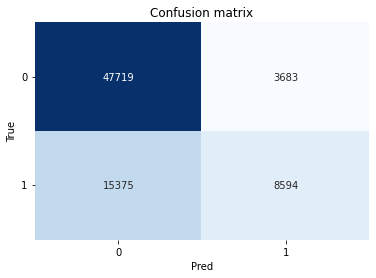

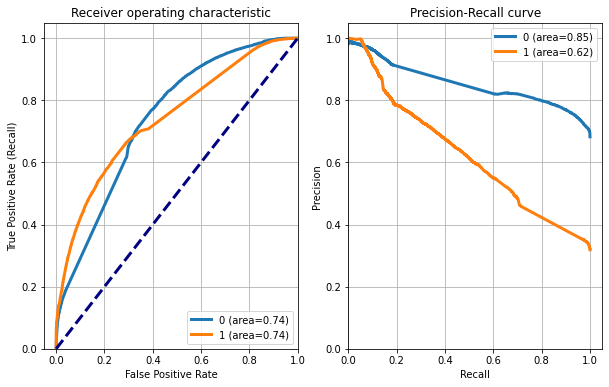

In [17]:
X_test = df_test["text_clean"].values
predicted_prob = model.predict_proba(X_test)
performance_report(y_test, predicted_prob, 0.7)

In [18]:
predicted = predicted_prob[:, 1] > 0.4924927679867334

## select observation
i = 3
txt_instance = df_test[var_used].iloc[i]
## check true value and predicted value
print("True:", y_test[i], "--> Pred:", predicted[i], "| Prob:", round(np.max(predicted_prob[i]),2))
## show explanation
explainer = lime_text.LimeTextExplainer(class_names=
             np.unique(y_train))
explained = explainer.explain_instance(txt_instance, 
             model.predict_proba, num_features=3)
explained.show_in_notebook(text=txt_instance, predict_proba=False)

True: 0 --> Pred: False | Prob: 0.67


# Random Forest Classifier

In [19]:
## pipeline
classifier = RandomForestClassifier()

model_rf = pipeline.Pipeline([("vectorizer", vectorizer),  
                           ("classifier", classifier)])

## train classifier
model_rf["classifier"].fit(X_train, y_train)

## test
X_test = df_test["text_clean"].values
predicted = model_rf.predict(X_test)
predicted_prob = model_rf.predict_proba(X_test)

Probability Threshold:  0.44183333333333336
Accuracy: 0.77
Auc: 0.77
Detail:
              precision    recall  f1-score   support

           0       0.79      0.90      0.84     51402
           1       0.70      0.49      0.57     23969

    accuracy                           0.77     75371
   macro avg       0.75      0.69      0.71     75371
weighted avg       0.76      0.77      0.76     75371



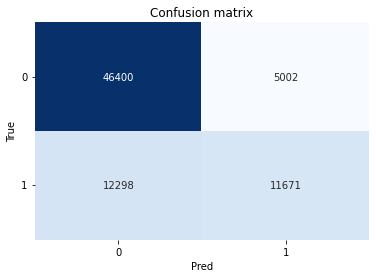

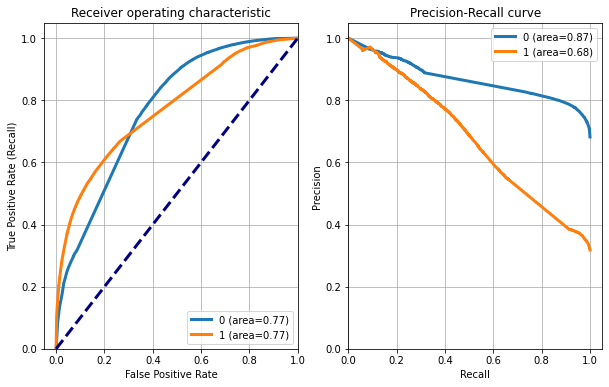

In [20]:
# make predictions
predicted_prob = model_rf.predict_proba(X_test)
performance_report(y_test, predicted_prob, 0.7)

# Gradient Boosting Classifier

In [21]:
## pipeline
classifier = GradientBoostingClassifier()

model_gb = pipeline.Pipeline([("vectorizer", vectorizer),  
                           ("classifier", classifier)])

## train classifier
model_gb["classifier"].fit(X_train, y_train)

## test
X_test = df_test["text_clean"].values
predicted = model_gb.predict(X_test)
predicted_prob = model_gb.predict_proba(X_test)

Probability Threshold:  0.44312126493402754
Accuracy: 0.74
Auc: 0.72
Detail:
              precision    recall  f1-score   support

           0       0.74      0.94      0.83     51402
           1       0.70      0.29      0.41     23969

    accuracy                           0.74     75371
   macro avg       0.72      0.62      0.62     75371
weighted avg       0.73      0.74      0.70     75371



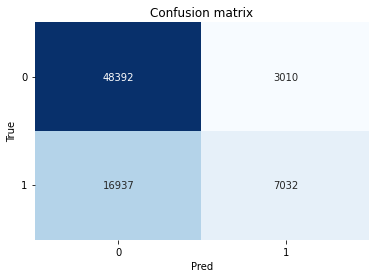

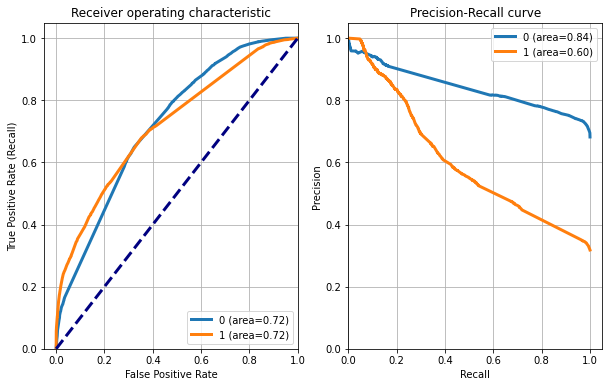

In [22]:
# make predictions
predicted_prob = model_gb.predict_proba(X_test)
performance_report(y_test, predicted_prob, 0.7)